In [1]:
#import warnings
#warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from glob2 import glob
import re
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# To read the temperature from the file
def get_temperature(text):
    return re.findall(r"[-+]?\d*\.\d+|\d+", text)[0]


# To read the numeric data from the file 
def get_readings(dat_file):
    df = pd.read_csv(dat_file, sep='\s+', skiprows=18, error_bad_lines=False, warn_bad_lines=False)
    df = df[pd.to_numeric(df.FL_Signal, errors='coerce').notnull()]
    df = df.apply(pd.to_numeric)
    return df

# Read all the files
def read_all_files(filepath, wavelength_threshold=310):
    df = pd.DataFrame()
    for dat_file in glob(filepath):
        with open(dat_file, 'r') as f:
            lines = f.readlines()
            temperature = float(get_temperature(lines[7]))
        if df.empty:
            df = get_readings(dat_file)
            df.rename({'FL_Signal': temperature}, axis=1, inplace=True)
            df.drop(['FL_Dynode'], axis=1, inplace=True)
        else:
            temp_df = get_readings(dat_file)
            df[temperature]=temp_df['FL_Signal']

    my_dataframe = pd.DataFrame()
    my_dataframe['wavelength'] = df.X
    df.drop(['X'], axis=1, inplace=True)
    df = df.reindex(sorted(df.columns), axis=1)
    my_dataframe = pd.concat([my_dataframe, df], axis=1)
    my_dataframe = my_dataframe[my_dataframe.wavelength > 310]
    return my_dataframe

def fit_line(df, temp_low=4, temp_high=20, plot=True):
    T_inv_min = 1/(temp_high + 273.15)
    T_inv_max = 1/(temp_low + 273.15)
    temp_df = df[(df.T_inv>=T_inv_min) & (df.T_inv<=T_inv_max)]
    reg = LinearRegression().fit(temp_df['T_inv'].values.reshape(-1, 1), temp_df['ln(Q_inv - 1)'])
    slope = reg.coef_[0]
    intercept = reg.intercept_
    if plot:
        plt.scatter(df['T_inv'], df['ln(Q_inv - 1)'])
        plt.plot(temp_df['T_inv'], reg.predict(temp_df['T_inv'].values.reshape(-1, 1)), color='r', linewidth=2)
        plt.xlim(xmin= np.min(df['T_inv']), xmax=np.max(df['T_inv']))
    return slope, intercept

In [3]:
# Put the right filepath
df = read_all_files("uday_FL_data/*.dat")
df

,wavelength,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,...,80.0,82.0,84.0,86.0,88.0,90.0,92.0,94.0,96.0,98.0
0,450.000,0.080,0.080,0.081,0.080,0.080,0.081,0.081,0.080,0.081,...,0.079,0.079,0.079,0.079,0.078,0.078,0.078,0.077,0.078,0.078
1,449.000,0.081,0.081,0.082,0.081,0.081,0.081,0.080,0.081,0.081,...,0.078,0.079,0.079,0.077,0.079,0.078,0.079,0.078,0.078,0.078
2,448.000,0.081,0.081,0.080,0.081,0.082,0.080,0.081,0.082,0.082,...,0.079,0.080,0.079,0.079,0.078,0.079,0.079,0.078,0.078,0.079
3,447.000,0.081,0.081,0.082,0.082,0.082,0.081,0.082,0.081,0.082,...,0.079,0.079,0.079,0.079,0.079,0.078,0.079,0.078,0.078,0.077
4,446.000,0.082,0.081,0.082,0.082,0.081,0.082,0.081,0.081,0.082,...,0.079,0.079,0.079,0.079,0.079,0.078,0.078,0.078,0.078,0.077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,314.001,0.339,0.332,0.325,0.317,0.311,0.305,0.296,0.290,0.286,...,0.167,0.163,0.162,0.161,0.157,0.156,0.154,0.154,0.150,0.151
137,313.001,0.325,0.318,0.309,0.301,0.297,0.290,0.285,0.277,0.265,...,0.166,0.162,0.162,0.159,0.157,0.158,0.154,0.152,0.150,0.148
138,312.001,0.310,0.303,0.299,0.289,0.283,0.276,0.270,0.261,0.260,...,0.163,0.160,0.156,0.157,0.154,0.153,0.152,0.150,0.148,0.146
139,311.001,0.295,0.290,0.283,0.278,0.271,0.266,0.261,0.252,0.247,...,0.161,0.158,0.155,0.155,0.153,0.152,0.150,0.151,0.148,0.144


### Only for viewing the low temperature data

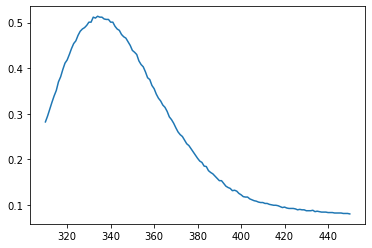

In [4]:
# Plot the Fluoroscence signal at low temperature
low_temperature = 4.0
plt.plot(df.wavelength, df[low_temperature])

### To get the $Q_{max}$

In [5]:
def get_q_max(df, temperature=4.0):
    Q_max = df.wavelength[df[temperature]==np.max(df[temperature])].values[0]
    return Q_max

Q_max = get_q_max(df, 4.0)
Q = "Q"+str(int(Q_max))
print(Q)

Q334


In [6]:
peak = np.max(df[4.0])
print("Fluoroscence peak (at temperature 4°C) is at", peak)
df2 = df[df[4.0] == peak].T[1:]
df2.columns = [Q]
df2['T_inv'] = 1/ (df2.index + 273.15)
df2['ln(Q_inv - 1)'] = np.log(1/df2[Q] - 1)

Fluoroscence peak (at temperature 4°C) is at 0.514


### View the $T^{-1}$ vs $ln(Q^{-1} - 1)$  as well as the visualisation of the fit

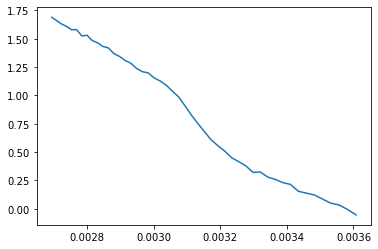

In [7]:
plt.plot(df2['T_inv'], df2['ln(Q_inv - 1)'])

-1238.3548571315348 4.423793300693215


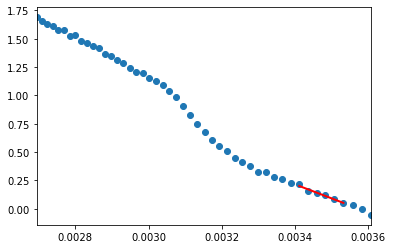

In [8]:
# Find the slope and intercept for the lower temperature range 4°C to 20°C
slope, intercept = fit_line(df2, 10, 20)
print(slope, intercept)

-1727.7985487288531 6.3409134110425285


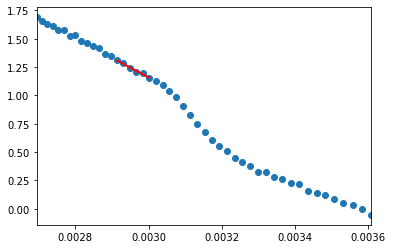

In [9]:
# Find the slope and intercept for the higher temperature range 55°C to 70°C
slope, intercept = fit_line(df2, 60, 70)
print(slope, intercept)

### Find F0, Fd and Fu 
Manually modify line 1 and line 3 to set the low and high temperature ranges as shown in the comments

In [10]:
# Find 'F0'. Set appropriate low and high temperature range
slope, intercept = fit_line(df2, temp_low=10, temp_high=20, plot=False)  
df2['F0'] = np.power((1 + np.exp(slope*df2['T_inv'])*np.exp(intercept)), -1)

# Find 'Fd'. Set appropriate low and high temperature range
slope, intercept = fit_line(df2, temp_low=60, temp_high=70, plot=False)
df2['Fd'] = np.power((1 + np.exp(slope*df2['T_inv'])*np.exp(intercept)), -1)

# Find 'Fu'
df2['Fu'] = (df2['Q334'] - df2['F0'])/(df2['Fd'] - df2['F0'])

### Visualize the final table with all the relevant features

In [11]:
df2

,Q334,T_inv,ln(Q_inv - 1),F0,Fd,Fu
4.0,0.514,0.003608,-0.056015,0.511094,0.473338,-0.076975
6.0,0.502,0.003582,-0.008000,0.503092,0.462218,0.026725
8.0,0.492,0.003557,0.032003,0.495203,0.451294,0.072951
10.0,0.488,0.003532,0.048009,0.487428,0.440569,-0.012210
12.0,0.479,0.003507,0.084049,0.479767,0.430049,0.015437
14.0,0.470,0.003483,0.120144,0.472223,0.419737,0.042356
16.0,0.466,0.003458,0.136210,0.464796,0.409635,-0.021836
18.0,0.462,0.003435,0.152294,0.457485,0.399747,-0.078194
20.0,0.447,0.003411,0.212799,0.450293,0.390073,0.054675
22.0,0.443,0.003388,0.228995,0.443218,0.380613,0.003476


### Fit the final curve

In [12]:
# Function to fit
def func(x, S, H):
    return np.power((1 + np.exp(S - H/x)), -1)

In [13]:
# call the above function
popt, pcov = curve_fit(func, 1/df2['T_inv'], df2['Fu'])

### Visually the fit curve

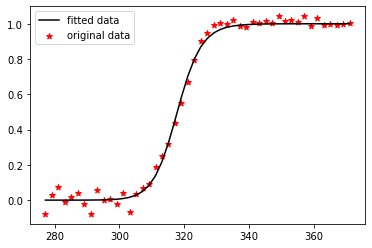

In [14]:
plt.scatter(1/df2['T_inv'], df2['Fu'], marker='*', color='r', label='original data')
plt.plot(1/df2['T_inv'], func(1/df2['T_inv'], *popt), color='k', label='fitted data')
plt.legend()

In [15]:
S, H = popt

### Find the melting temperature

In [16]:
Tm = H/(S-np.log(1))

#Convert to Kelvin
print("Melting Temperature is", Tm - 273.15)

Melting Temperature is 44.71507967286465
